In [2]:
import os
import cv2
import time
import argparse
import multiprocessing
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

In [1]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [3]:
CWD_PATH = os.getcwd()

# Path to frozen detection graph. This is the actual model that is used for the object detection.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

PATH_TO_CKPT = os.path.join(CWD_PATH, MODEL_NAME, 'frozen_inference_graph.pb')

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join(CWD_PATH, 'data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

In [9]:
# download model
import six.moves.urllib as urllib
import tarfile

opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

In [4]:
print(PATH_TO_CKPT)
print(PATH_TO_LABELS)

/Users/sophie/pyenvironments/obj-detection/ssd_mobilenet_v1_coco_2017_11_17/frozen_inference_graph.pb
/Users/sophie/pyenvironments/obj-detection/data/mscoco_label_map.pbtxt


In [5]:
# load frozen model into memory
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [6]:
# loading label map
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, 
                                                            use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [7]:
label_map

item {
  name: "/m/01g317"
  id: 1
  display_name: "person"
}
item {
  name: "/m/0199g"
  id: 2
  display_name: "bicycle"
}
item {
  name: "/m/0k4j"
  id: 3
  display_name: "car"
}
item {
  name: "/m/04_sv"
  id: 4
  display_name: "motorcycle"
}
item {
  name: "/m/05czz6l"
  id: 5
  display_name: "airplane"
}
item {
  name: "/m/01bjv"
  id: 6
  display_name: "bus"
}
item {
  name: "/m/07jdr"
  id: 7
  display_name: "train"
}
item {
  name: "/m/07r04"
  id: 8
  display_name: "truck"
}
item {
  name: "/m/019jd"
  id: 9
  display_name: "boat"
}
item {
  name: "/m/015qff"
  id: 10
  display_name: "traffic light"
}
item {
  name: "/m/01pns0"
  id: 11
  display_name: "fire hydrant"
}
item {
  name: "/m/02pv19"
  id: 13
  display_name: "stop sign"
}
item {
  name: "/m/015qbp"
  id: 14
  display_name: "parking meter"
}
item {
  name: "/m/0cvnqh"
  id: 15
  display_name: "bench"
}
item {
  name: "/m/015p6"
  id: 16
  display_name: "bird"
}
item {
  name: "/m/01yrx"
  id: 17
  display_name: "cat

In [8]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [9]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 4) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [10]:
print(TEST_IMAGE_PATHS)

['test_images/image1.jpg', 'test_images/image2.jpg', 'test_images/image3.jpg']


In [11]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

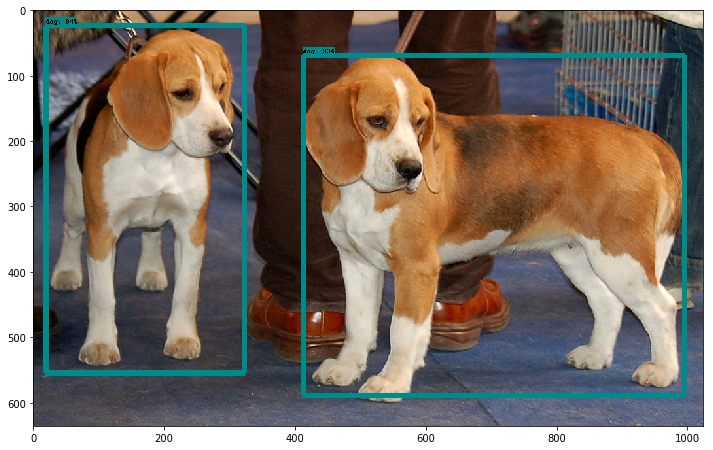

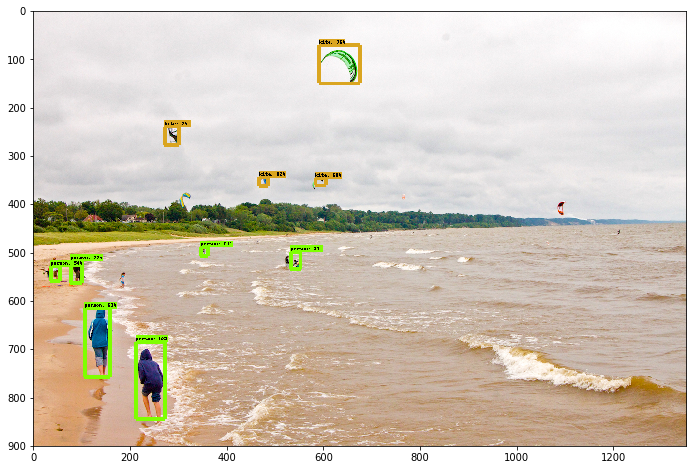

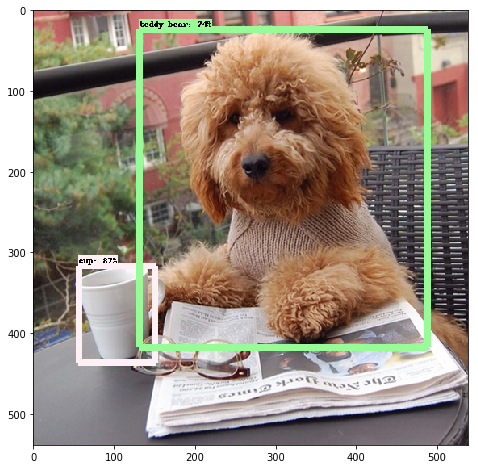

In [12]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

(1024, 636) (636, 1024, 3)
(1352, 900) (900, 1352, 3)
(539, 539) (539, 539, 3)


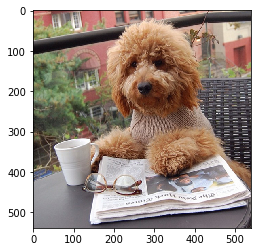

In [13]:
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    image_np = load_image_into_numpy_array(image)
    plt.imshow(image_np)
    print(image.size, image_np.shape)